# Importing the libraries

In [1]:
from bs4 import BeautifulSoup # scrape websites
import requests
from geopy.geocoders import Nominatim # reverse geocoding
import folium # map rendering library

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

import keyring #handle secrets
import getpass

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Getting the data

## Scrape the data

Scrape the data from Wikipedia to get the most important cities of each country.

In [2]:
def get_cities_data(country):
    url = "https://en.wikipedia.org/wiki/" + country

    # Make a GET request to fetch the raw HTML content
    html_content = requests.get(url).text

    # Parse the html content
    soup = BeautifulSoup(html_content, "lxml")

    # Get the table we need
    tables = soup.find_all("table", {"class": "navbox"})

    final_headers = []  # listo to save the headers
    table_contents = []  # list to save the data

    # Loop through the tables on the page
    # to find the one we need
    for t in tables:
        rows = t.find_all("tr")

        # Loop through rows
        for r in rows:
            cell = {}
            heading = r.find_all("th")
            details = r.find_all("td")

            # Save headings
            head_list = []
            if heading is not None:
                for x in heading:
                    head_list.append(x.text.replace("\n", ""))

            if not head_list:
                pass
            else:
                final_headers = head_list[1:5]

            # Save rows
            if details is not None and len(details) >= 4:
                # print(heading, details)4
                start = 1 if len(details) == 6 else 0
                cell["1"] = details[0 + start].text
                cell["2"] = details[1 + start].text
                cell["3"] = details[2 + start].text
                cell["4"] = details[3 + start].text.replace("\n", "")
                cell["5"] = country.replace("_", " ")

            if not cell:
                pass
            else:
                table_contents.append(cell)

    return table_contents

In [3]:
countries = ['Costa_Rica', 'Nicaragua', 'El_Salvador', 'Honduras', 'Guatemala', 'Panama', 'Belize']
resultados = []

for i in countries:
    resultados.extend(get_cities_data(i))

df = pd.DataFrame(resultados)
df.columns = ['Rank', 'City', 'Province', 'Population', 'Country']
df.head()

Rank        City    Province Population     Country
0    1    San José    San José    342 188  Costa Rica
1    2    Alajuela    Alajuela    276 794  Costa Rica
2    3     Cartago     Cartago    151 744  Costa Rica
3    4     Heredia     Heredia    128 550  Costa Rica
4    5  Puntarenas  Puntarenas    122 335  Costa Rica

## Getting coordinates

In [4]:
def get_coordinates(geolocator, city, province, country):
    try:
        location = geolocator.geocode(city + ", " + province + ", " + country)

        lat = location.latitude
        lon = location.longitude
        return (lat, lon)
    except:
        return (None, None)

In [5]:
geolocator = Nominatim(user_agent="Coursera Capstone Project")

get_coordinates(geolocator, "San José", "San José", "Costa Rica")

(9.9325427, -84.0795782)

In [6]:
lat_longs = [get_coordinates(geolocator, x,y,z) for x,y,z in zip(df['City'],df['Province'],df['Country'])]

In [7]:
df['latitude'] = [x[0] for x in lat_longs]
df['longitude'] = [x[1] for x in lat_longs]
df.dropna(inplace=True)

In [8]:
df.shape

(63, 7)

In [9]:
# create map of New York using latitude and longitude values
toronto = folium.Map(location=[df['latitude'][0], df['longitude'][0]], zoom_start=5)

# add markers to map
for lat, lng, city, country in zip(df['latitude'], df['longitude'], df['City'], df['Country']):
    label = '{}, {}'.format(city, country)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto)  
    
toronto

# Getting venues in each city

Set information required to use the FourSquare API

In [10]:
# Use to set the secrets
# keyring.set_password('Foursquare_API', 'CLIENT_ID', getpass.getpass())
# keyring.set_password('Foursquare_API', 'CLIENT_SECRET', getpass.getpass())
CLIENT_ID = keyring.get_password("Foursquare_API", "CLIENT_ID")
CLIENT_SECRET = keyring.get_password("Foursquare_API", "CLIENT_SECRET")
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Define function to get nearby venues for each neighborhood

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=3000):
    
    venues_list=[] # store the data
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    # Create dataframe from the list 
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City Country', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Code to run the above function on each neighborhood and create a new dataframe.

In [12]:
total_venues = getNearbyVenues(
    (df["City"] + ", " + df["Country"]).values,
    df["latitude"].values,
    df["longitude"].values,
)
total_venues['value'] = 1
total_venues = total_venues[total_venues['Venue Category'] != 'City']

In [13]:
total_venues.head()

City Country  City Latitude  City Longitude  \
0  San José, Costa Rica       9.932543      -84.079578   
1  San José, Costa Rica       9.932543      -84.079578   
2  San José, Costa Rica       9.932543      -84.079578   
3  San José, Costa Rica       9.932543      -84.079578   
4  San José, Costa Rica       9.932543      -84.079578   

                           Venue  Venue Latitude  Venue Longitude  \
0  Teatro Popular Melico Salazar        9.933164       -84.079361   
1                Teatro Nacional        9.933170       -84.077362   
2                 Café La Mancha        9.934295       -84.078252   
3                     Yogurberry        9.933338       -84.077455   
4      La Sorbetera de Lolo Mora        9.934467       -84.081841   

   Venue Category  value  
0         Theater      1  
1         Theater      1  
2            Café      1  
3  Ice Cream Shop      1  
4  Ice Cream Shop      1

In [14]:
# create map of New York using latitude and longitude values
venues_map = folium.Map(location=[df['latitude'][0], df['longitude'][0]], zoom_start=5)

# add markers to map
for lat, lng, city, country in zip(total_venues['Venue Latitude'], total_venues['Venue Longitude'], total_venues['Venue'], total_venues['Venue Category']):
    label = '{}, {}'.format(city, country)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#000d54.ipynb_checkpoints/',
        fill_opacity=0.7,
        parse_html=False).add_to(venues_map)  
    
venues_map

In [15]:
df1 = total_venues.pivot_table(
    index="City Country",
    columns="Venue Category",
    values="value",
    aggfunc="sum",
    fill_value=0,
)
#data_groups = df1.reset_index(drop=True)

In [16]:
df1.head()

Venue Category           Accessories Store  Airport  Airport Lounge  \
City Country                                                          
1, El Salvador                           0        0               0   
Ahuachapán, El Salvador                  0        0               0   
Alajuela, Costa Rica                     0        1               0   
Apopa, El Salvador                       0        0               0   
Arraiján, Panama                         0        0               0   

Venue Category           Airport Service  Airport Terminal  \
City Country                                                 
1, El Salvador                         0                 0   
Ahuachapán, El Salvador                0                 0   
Alajuela, Costa Rica                   0                 0   
Apopa, El Salvador                     0                 0   
Arraiján, Panama                       0                 0   

Venue Category           American Restaurant  Arcade  Arepa Restaurant  \
City Country                                                             
1, El Salvador                             1       0                 0   
Ahuachapán, El Salvador                    0       0                 1   
Alajuela, Costa Rica                       1       0                 0   
Apopa, El Salvador                         1       1                 0   
Arraiján, Panama                           0       0                 0   

Venue Category           Argentinian Restaurant  Art Gallery  ...  \
City Country                                                  ...   
1, El Salvador                                1            0  ...   
Ahuachapán, El Salvador                       0            0  ...   
Alajuela, Costa Rica                          0            0  ...   
Apopa, El Salvador                            0            0  ...   
Arraiján, Panama                              0            0  ...   

Venue Category           Video Store  Volleyball Court  Warehouse Store  \
City Country                                                              
1, El Salvador                     0                 1                0   
Ahuachapán, El Salvador            0                 0                0   
Alajuela, Costa Rica               0                 0                0   
Apopa, El Salvador                 0                 1                0   
Arraiján, Panama                   0                 0                0   

Venue Category           Water Park  Wine Bar  Wine Shop  Wings Joint  \
City Country                                                            
1, El Salvador                    0         0          0            0   
Ahuachapán, El Salvador           0         0          0            0   
Alajuela, Costa Rica              0         0          0            0   
Apopa, El Salvador                0         0          0            0   
Arraiján, Panama                  0         0          0            0   

Venue Category           Women's Store  Yoga Studio  Zoo  
City Country                                              
1, El Salvador                       0            0    0  
Ahuachapán, El Salvador              0            0    0  
Alajuela, Costa Rica                 0            0    0  
Apopa, El Salvador                   0            0    0  
Arraiján, Panama                     0            0    0  

[5 rows x 245 columns]

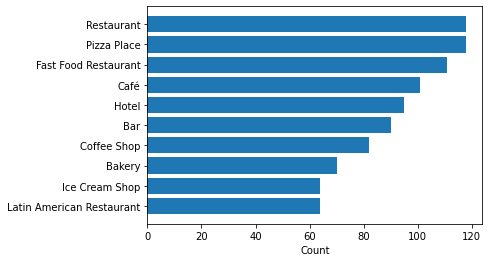

In [17]:
tops=df1.sum(skipna=True).sort_values(ascending=False).nlargest(10)

plt.barh(tops.index,tops.values)
plt.ylabel('')
plt.xlabel('Count')
plt.gca().invert_yaxis()
plt.show()

# Cluster Neighborhoods

In [18]:
square_distances = []
silhouettes = []

for k in range(2,20):
    km = KMeans(n_clusters=k, n_init=100, random_state=0).fit(df1.values)
    square_distances.append(km.inertia_)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    cluster_labels = km.labels_
    silhouette_avg = silhouette_score(df1.values, cluster_labels)
    silhouettes.append(silhouette_avg)

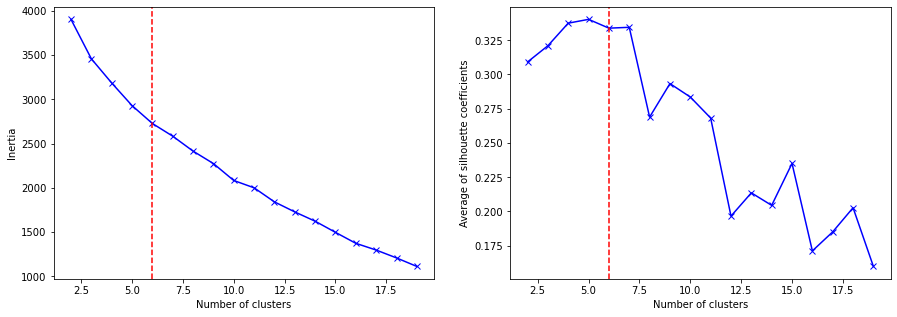

In [19]:
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

axs[0].plot(range(2,20), square_distances, 'bx-')
axs[0].axvline(6, linestyle='--', color='red')
axs[0].set_xlabel('Number of clusters')
axs[0].set_ylabel('Inertia')
#axs[0].set_title('Elbow Method For Optimal k')


axs[1].plot(range(2,20), silhouettes, 'bx-')
axs[1].axvline(6, linestyle='--', color='red')
axs[1].set_xlabel('Number of clusters')
axs[1].set_ylabel('Average of silhouette coefficients')
#axs[1].set_title('Elbow Method For Optimal k')
plt.show()

## Fit the clusters

Run _k_-means to cluster the neighborhoods into 6 clusters.

In [20]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, n_init=200).fit(df1.values)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 1, 3, 0, 1, 1, 4, 1, 1, 1], dtype=int32)

In [21]:
pd.DataFrame(np.unique(kmeans.labels_, return_counts=True))

0   1  2  3  4  5
0  0   1  2  3  4  5
1  5  36  1  5  5  6

In [22]:
# add clustering labels
df2 = pd.DataFrame(kmeans.labels_ , index=df1.index)
df2.columns = ['Cluster']
df2.head()

Cluster
City Country                    
1, El Salvador                 5
Ahuachapán, El Salvador        1
Alajuela, Costa Rica           3
Apopa, El Salvador             0
Arraiján, Panama               1

In [23]:
venues_merge = df2
venues_merge = venues_merge.join(total_venues.set_index('City Country'), on='City Country')
venues_merge.reset_index(drop=False, inplace=True)
venues_merge.head() # check the last columns!

City Country  Cluster  City Latitude  City Longitude  \
0  1, El Salvador        5      13.673653      -89.220294   
1  1, El Salvador        5      13.673653      -89.220294   
2  1, El Salvador        5      13.673653      -89.220294   
3  1, El Salvador        5      13.673653      -89.220294   
4  1, El Salvador        5      13.673653      -89.220294   

                            Venue  Venue Latitude  Venue Longitude  \
0     Parque Residencial Altamira       13.675799       -89.221891   
1                  Subway La Cima       13.669398       -89.227718   
2            Gambeta Los Proceres       13.679702       -89.227830   
3               Estadio Cuscatlán       13.681057       -89.222331   
4  Pizza Nova (Plaza Las Acacias)       13.676517       -89.227459   

   Venue Category  value  
0            Park      1  
1  Sandwich Place      1  
2  Soccer Stadium      1  
3  Soccer Stadium      1  
4     Pizza Place      1

In [24]:
graph_plot = venues_merge[venues_merge["Cluster"] == 0]

data_filter = graph_plot.groupby(['Venue Category']).count()[['value']]
keep_columns = data_filter.index[ data_filter['value'] >= 15 ].values

graph_plot = graph_plot.groupby([ 'City Country', 'Venue Category']).count()[['value']].unstack(1, fill_value=0)
graph_plot.columns = graph_plot.columns.droplevel(0)

graph_plot = graph_plot.loc[:, keep_columns]
graph_plot.head()

Venue Category          Café  Fast Food Restaurant  Latin American Restaurant  \
City Country                                                                    
Apopa, El Salvador         4                     4                          3   
Delgado, El Salvador       5                     3                          7   
Ilopango, El Salvador      4                     4                          5   
Mejicanos, El Salvador     4                     9                          1   
Soyapango, El Salvador     2                     7                          2   

Venue Category          Mexican Restaurant  Pizza Place  
City Country                                             
Apopa, El Salvador                       8            6  
Delgado, El Salvador                     7            3  
Ilopango, El Salvador                    8            5  
Mejicanos, El Salvador                   6           10  
Soyapango, El Salvador                   3            8

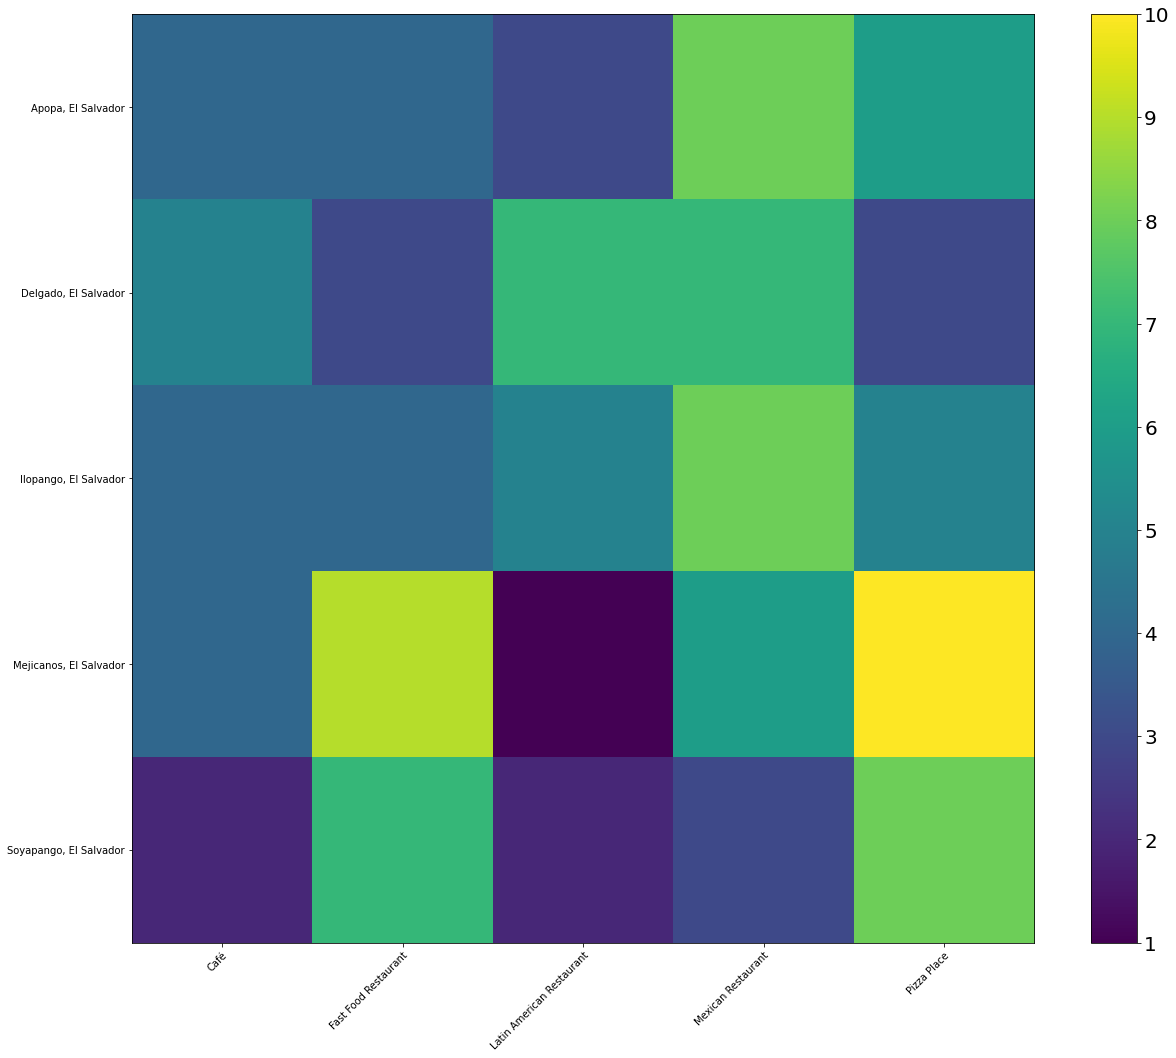

In [25]:
fig, ax = plt.subplots(figsize=(18, 15)) #
im = ax.imshow(graph_plot, aspect="auto", interpolation="none")


# We want to show all ticks...
ax.set_xticks(np.arange(graph_plot.shape[1]))
ax.set_yticks(np.arange(graph_plot.shape[0]))
# ... and label them with the respective list entries
ax.set_xticklabels(graph_plot.columns)
ax.set_yticklabels(graph_plot.index)



plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.rc('font', size=20)  
plt.rc('axes', labelsize=20) 

fig.tight_layout()
fig.colorbar(im)
plt.show()